## 日历策略
1. 整个数据都是在一个dataFrame 上处理的，再原来数据的基础上 + 仓位 + 各个的盈利率变化 + 再生成图渲染 + 算年化指标、最大回撤

         AnnRet    AnnVol        SR     MaxDD    Calmar
index  0.102206  0.225321  0.453603 -0.466961  0.218875
stgy   0.106254  0.114998  0.923959 -0.183745  0.578268


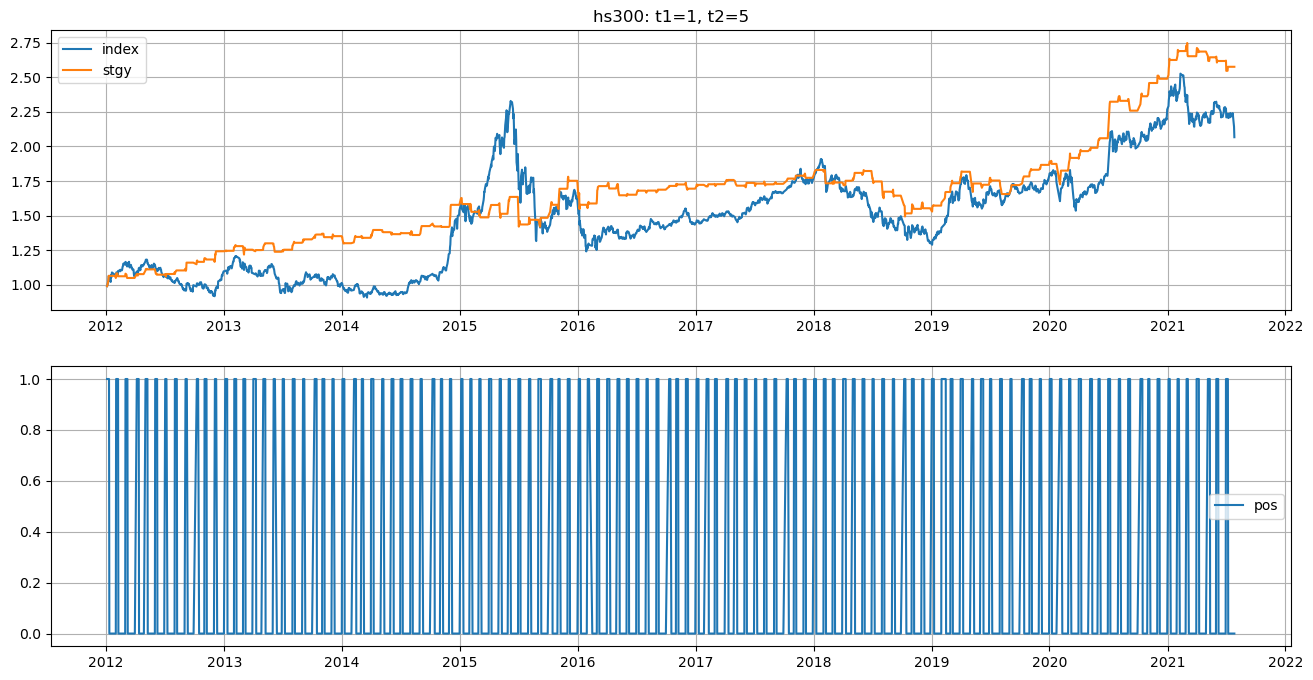

In [4]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""
总体语法总结：
    1. []数组 可变  ()元组 不可变
    2. in range（x，y）  X 到 Y-1 的整数序列
    3. pd.pct_change()    当前元素和前一个元素的百分比变化。
    4. pd.cumprod()   元素的累积乘积。
    5. pd.cummax()   查找序列的累积最大值,只增不减（每个元素都等于当前元素和前一个元素之间的较大者）
    6. 计算回撤最简单办法：两步    hmax = p.cummax()          return p / hmax - 1

"""


def get_drawdown(data):
    """
    回撤算法：需要数据当前盈利了多少了，标记盈利阶段最高点不回撤，（当前价格与阶段最高点进行除）-1 = 各个阶段回撤率。
    """
    length = len(data)
    hmax = [data[0]]
    # 小的被前面大的替换，整体是递增趋势的。 算是记录住最高点了，不让回退。
    hmax.extend(np.nanmax([data[cur], hmax[cur - 1]]) for cur in range(1, length))
    # 当前累计盈利 / 历史最高盈利  即为当前占最高的比例，-1即为变化回撤的比例。
    return [data[t] / hmax[t] - 1 for t in range(length)]


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标
    annret 年化收益 annualized returns：先根据盈利数据算出变化率，再一年变化率的平均值 * 250个交易日
    annvol  年化波动率  Annualized Volatility: 收益率的标准差 / np.sqrt(250)： 将日波动率（即收益率的标准差）转化为年波动率的常数调整因子
    sr 夏普率 Sharpe Ratio  ：超额收益 / 标准差(风险)
    calmar 卡玛比率： 超额收益 / 最大回撤(风险)
    dd 最大回撤
    """
    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=[
            'AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        return res

    ret = adjnav.pct_change()
    annret = np.nanmean(ret) * 242
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    drawdown = get_drawdown(adjnav)
    max_drawdown = np.nanmin(drawdown)
    calmar = annret / - max_drawdown
    return [annret, annvol, sr, max_drawdown, calmar]


def ymd_to_date(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()


def date_count_in_mouth(dates):
    """
    计算日期序列中每个日期在所在月中的序数,传过来的数据需要从月份首个交易日开始。
    """
    cur_count = 1
    counts = [cur_count]
    # 循环判断 只要和前面一个月份不同，出现变化 计数重新累计
    for i in range(1, len(dates)):
        cur_count = cur_count + 1 if dates[i].month == dates[i - 1].month else 1
        counts.append(cur_count)
    return counts


if __name__ == '__main__':
    data = pd.read_csv('指数历史数据.csv').set_index('datetime')
    data.index = [ymd_to_date(e) for e in data.index]

    # 设置回测参数
    column_name = 'hs300'  # 标的指数：'hs300' or 'csi500' or 'csi1000'
    start_time = datetime.date(2012, 1, 1)  # 回测起始日期
    end_time = datetime.date(2021, 7, 27)  # 回测截止日期
    owner_start = 1  # 每月持仓交易起始日，从1起
    owner_end = 5  # 每月持仓交易截止日，从1起

    # 回测
    df = data.loc[start_time:end_time, [column_name]]
    df['index_ret'] = df[column_name].pct_change()
    # 数组a的元素的累积乘积，hs300的累计盈利
    df['index'] = (1 + df['index_ret']).cumprod()
    df['date_count_in_month'] = date_count_in_mouth(df.index)

    # 标记仓位
    df['pos'] = [1 if (e >= owner_start and e <= owner_end)
                 else 0 for e in df['date_count_in_month']]
    df['stgy_ret'] = df['pos'] * df['index_ret']  # 仓位 * 增长率， 为盈利
    df['stgy'] = (1 + df['stgy_ret']).cumprod() # 累计盈利

    # 回测结果展示
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(2, 1, 1)
    df.loc[:, ['index', 'stgy']].plot(
        ax=ax1, grid=True, title='%s: t1=%d, t2=%d' % (column_name, owner_start, owner_end))
    ax2 = fig.add_subplot(2, 1, 2)
    df.loc[:, ['pos']].plot(ax=ax2, grid=True)

    res = cal_period_perf_indicator(df.loc[:, ['index', 'stgy']])
    print(res)
